# <center>CCF2019-阿尔茨海默症的识别</center>

* **赛题背景**

阿尔茨海默症：俗称“老年痴呆症”，多发于老人（听说已经往年轻化发展的趋势）。随之年龄增长患病的概率也陡然增加。至今还**没有客观明确的诊断方法**（并不像高血压关注血压值，糖尿病关注血糖值），也没有特效药（对老年痴呆有治愈作用，让记忆恢复到正常状态，目前只有控制病情发展的药）。病症到了后期，直接导致生活不能自理，需要人24小时陪伴。各大药厂都投入巨资（全球投入几十亿美元），针对病例检测（如何找到一个可靠客观确认方法），治疗和康复进行研究探索，但是多数都失败告终（虽然也有上市的药品、方法但是效果都有限）。所以赛题有很强的现实意义和探索性。

* **医疗数据特点**

医疗数据的比较难收集，主要是以下原因：

个人隐私问题
数据分散问题（大部分病并不是集中在特定地区，所以分布很随机）
收集成本高
数据标注、清洗困难
所以 医疗数据大部分都是“小数据集”（一个实验过程，有1~2百多人就算不小了），这对于以“大数据”为基础的深度学习矛盾，也许随着科技的发展，国家对医疗数据的重视，通过较长时间累积应该会有更多“大”的医疗数据集出现。针对本次竞赛而言因为数据量不大，模型的泛化能力没有办法验证，结果很可能是 **过拟合 Test集**。所以本次**探索意义大于结果成绩**。

* **MRI（磁共振）**

磁共振成像（MRI）是一种利用磁共振现象产生的信号来重建图像的成像技术。它只是相当于氢质子的振动，然后平静下来，去感受到图像中的振动的方式。优势：1.基于目前的研究，MRI对人体没有伤害；2.MRI可以获得脑和脊柱的立体图像，而CT图像则是组织的切片2D图像，使得医生很容易漏掉不明显的病变组织。劣势：1.对于肺部的诊断效果没有CT好，但是费用比CT高；2.对于胃肠道的病变检查效果不如内窥镜

赛会提供给就是MRI数据，结构是：(300,1,79,95,79) 。其中**300代表采样个体**（应该是患者人数），**1代表 通道数**，**79代表MRI数据切片层数**（切片并不是连续，大约间隔5mm一层，也可以根据需要减小间隙提高3D成像效果），**95*79代表切片图像**（浮点型灰度图）

<div align=center><img src='image/切片示例.jpg' width=20% height=20% />切片图像(放大四倍)</div>

<center>↑ 以上的图片就是从赛会给的H5文件抓取的切片图像（编号0，第41层）</center>

* **可视化分析**

有了背景知识和数据，我们就可以进行EDA（数据探索分析），探索方法并不固定，但推荐对数据进行可视化。可视化可以帮助加深对数据的理解，例如数据是H5的存储，里面存储的是什么数据，很难直接理解：

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

import imageio
from PIL import Image

import torch
import torch.nn as nn
from torch import optim

from sklearn.model_selection import train_test_split

import help
from Base3DModel import Base3DModel
from MyDataSet import MyDataset

对于样本标签，数字0代表阿尔茨海默症样本，数字1代表轻度认知障碍样本，数字2代表正常样本。对于csv格式的标签文件，字段id表示图像的序号，字段label表示图像对应标签。

In [2]:
print(help.features.shape)
print(help.labels.shape)
help.labels.head()

(300, 1, 79, 95, 79)
(300, 2)


,id,label
0,0,1
1,1,0
2,2,0
3,3,1
4,4,0


In [3]:
help.train['data'].shape

(300, 1, 79, 95, 79)

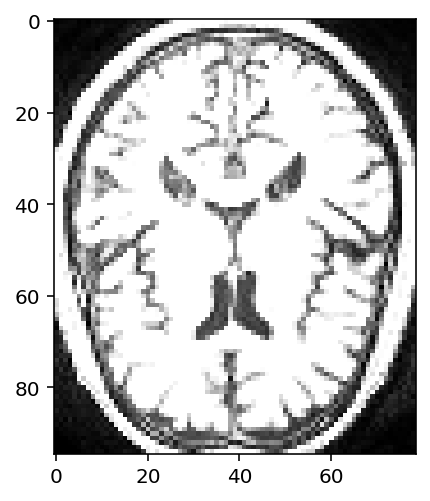

In [4]:
one_sample = help.features[0,0]
# 读取图片,灰度化，并转为数组
img = Image.fromarray(one_sample[40]).convert('L')
# Image.ANTIALIAS等比例缩放
img.resize((79*4,95*4),Image.ANTIALIAS).save('image/temp.jpg')#放大四倍以便观察
plt.imshow(img,cmap ='gray')

In [5]:
frames = []
for index in range(len(one_sample)):
    img = Image.fromarray(one_sample[index]).convert('L')
    img.resize((79*3, 95*3),Image.ANTIALIAS).save('image/temp{}.jpg'.format(index))
    frames.append(imageio.imread('image/temp{}.jpg'.format(index)))
imageio.mimsave('image/{0}.gif'.format('1'), frames, 'GIF', duration = 0.1)

<center><img id="img1" src="image/1.gif">数据集样本，间隔0.1S顺序播放切片图片，放大3倍</img></center>

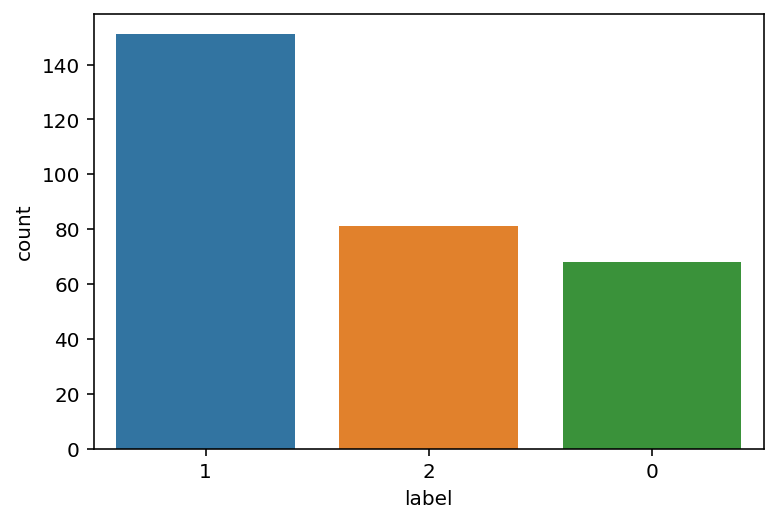

In [6]:
order = help.labels['label'].value_counts().index
sb.countplot(data=help.labels,x='label',order=order);

上图可以看出大部分样本是轻度认知障碍，正常样本略多于阿尔茨海默症样本

**torch.nn.Conv3D**

3D卷积, 输入的shape是(N,Cin,D,H,W)，输出shape (N,Cout,Dout,Hout,Wout)

__N__ 就是batch_size,无话可说,

__Cin__ 则对应着输入图像的通道数，如RGB\BGR图像这一维度就是3；

__D__ 则是深度，如果是对于视频序列使用的3d conv，那么这个D实际对应的就是要执行卷积的frame_size，

__H,W__ 对应的就是输入图像的高和宽

使用的时候如果不指定具体size，如:$\color{red}{padding=2}$，则是每一维度都为size是2的padding，也就是$\color{red}{padding=(2,2,2)}$；如果指定每一维的padding的话则有就是指定的size，如:$\color{red}{padding=(3,2,1)}$，则是分别是在三个维度上有3,2,1三种不同的padding，另外$\color{red}{kernel}$和$\color{red}{stride}$也是如此

<center><img id="img1" width="300px" height="300px" src="image/3D卷积.webp">3D卷积</img></center>

图片中的 Time轴 = 切片，Latitutde = 图片的width轴， Longitude = 图片的height轴，本次医疗数据是灰度图，不存在色彩通道

3D卷积，经过卷积层后，结果还是3D的数据，保留了“时空的特征”

In [7]:
X_train, X_val, y_train, y_val = train_test_split(help.features,help.labels['label'].values,test_size = 0.2,random_state = 42)

In [8]:
train_datasets = MyDataset(datas=X_train,labels=y_train,shape=3,input_D=help.input_D,input_H=help.input_H,input_W=help.input_W,phase='train')
val_datasets = MyDataset(datas=X_val,labels=y_val,shape=3,input_D=help.input_D,input_H=help.input_H,input_W=help.input_W,phase='train')

train_loader = torch.utils.data.DataLoader(dataset=train_datasets, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_datasets, batch_size=4, shuffle=False)
print("Data load success")

Data load success


In [9]:
basemodel_3d = Base3DModel(num_seg_classes=help.num_seg_classes,f=help.basemodel_3d_f)
basemodel_3d

Base3DModel(
  (conv): Sequential(
    (conv1): Conv3d(1, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (conv2): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (conv3): ReLU(inplace)
    (conv4): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv5): Conv3d(32, 256, kernel_size=(2, 2, 2), stride=(1, 1, 1), dilation=(2, 2, 2))
    (conv6): InstanceNorm3d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (conv7): ReLU(inplace)
    (conv8): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv9): Conv3d(256, 512, kernel_size=(2, 2, 2), stride=(1, 1, 1), padding=(2, 2, 2), dilation=(2, 2, 2))
    (conv10): InstanceNorm3d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (conv11): ReLU(inplace)
    (conv12): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv13): Conv3d(512, 512, kernel_size=(2, 2, 2),

Epochs: 1/100... Trian Loss:774.188... Trian Accuracy:0.492... Trian F1 Score:0.442... Val Loss:502.072... Val Accuracy:0.183... Val F1 Score:0.103
Epochs: 2/100... Trian Loss:137.239... Trian Accuracy:0.671... Trian F1 Score:0.590... Val Loss:86.366... Val Accuracy:0.817... Val F1 Score:0.577
Epochs: 3/100... Trian Loss:158.815... Trian Accuracy:0.750... Trian F1 Score:0.674... Val Loss:235.260... Val Accuracy:0.817... Val F1 Score:0.577
Epochs: 4/100... Trian Loss:168.346... Trian Accuracy:0.746... Trian F1 Score:0.665... Val Loss:108.645... Val Accuracy:0.750... Val F1 Score:0.532
Epochs: 5/100... Trian Loss:60.506... Trian Accuracy:0.729... Trian F1 Score:0.645... Val Loss:10.252... Val Accuracy:0.817... Val F1 Score:0.577
Epochs: 6/100... Trian Loss:24.469... Trian Accuracy:0.725... Trian F1 Score:0.641... Val Loss:9.112... Val Accuracy:0.750... Val F1 Score:0.532
Epochs: 7/100... Trian Loss:9.567... Trian Accuracy:0.758... Trian F1 Score:0.685... Val Loss:0.431... Val Accuracy:0.

Epochs: 58/100... Trian Loss:0.204... Trian Accuracy:0.925... Trian F1 Score:0.901... Val Loss:0.135... Val Accuracy:0.967... Val F1 Score:0.947
Epochs: 59/100... Trian Loss:0.184... Trian Accuracy:0.929... Trian F1 Score:0.907... Val Loss:0.120... Val Accuracy:0.950... Val F1 Score:0.920
Epochs: 60/100... Trian Loss:0.206... Trian Accuracy:0.912... Trian F1 Score:0.885... Val Loss:0.123... Val Accuracy:0.950... Val F1 Score:0.920
Epochs: 61/100... Trian Loss:0.190... Trian Accuracy:0.925... Trian F1 Score:0.902... Val Loss:0.123... Val Accuracy:0.950... Val F1 Score:0.920
Epochs: 62/100... Trian Loss:0.196... Trian Accuracy:0.917... Trian F1 Score:0.890... Val Loss:0.120... Val Accuracy:0.950... Val F1 Score:0.920
Epochs: 63/100... Trian Loss:0.209... Trian Accuracy:0.917... Trian F1 Score:0.890... Val Loss:0.126... Val Accuracy:0.950... Val F1 Score:0.920
Epochs: 64/100... Trian Loss:0.193... Trian Accuracy:0.925... Trian F1 Score:0.902... Val Loss:0.122... Val Accuracy:0.950... Val 

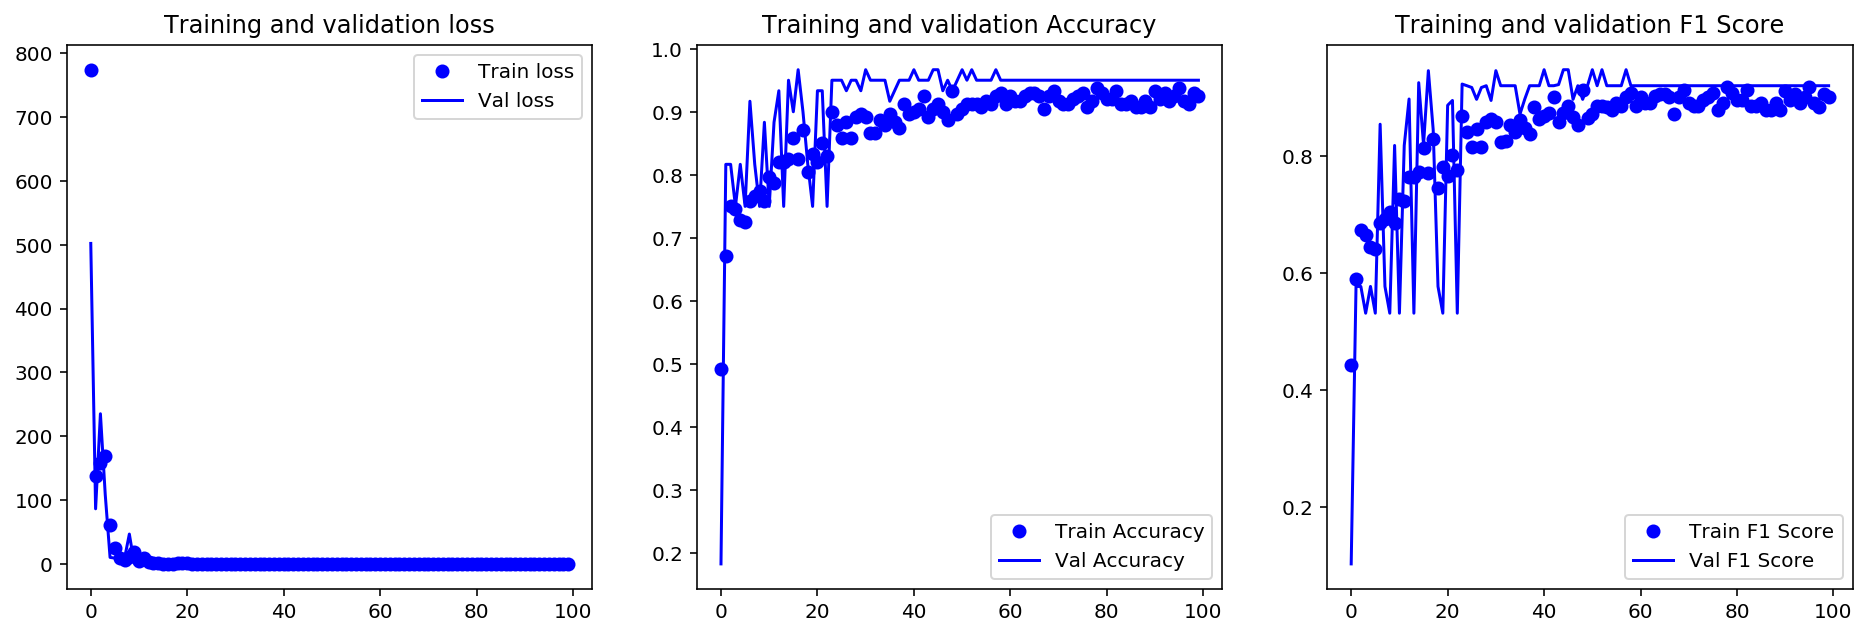

Training time is 53m 55s


In [10]:
epochs = 100
optimizer = optim.Adam(basemodel_3d.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
help.train_data(basemodel_3d,train_loader,val_loader,epochs,optimizer,scheduler,help.criterion,help.basemodel_3d_checkpoint_path,help.device)


In [11]:
loadmodel = help.load_checkpoint(help.basemodel_3d_checkpoint_path,'basemodel_3d',help.device)

In [12]:
test_datasets = MyDataset(datas=help.temp_data,shape=3,input_D=help.input_D,input_H=help.input_H,input_W=help.input_W,phase='test')

test_loader = torch.utils.data.DataLoader(dataset=test_datasets)

In [13]:
help.all_predict(test_loader,loadmodel,help.device,help.result_3d_basemodel)

0 test data have been predicted
----------------------------------------
20 test data have been predicted
----------------------------------------
40 test data have been predicted
----------------------------------------
60 test data have been predicted
----------------------------------------
80 test data have been predicted
----------------------------------------
100 test data have been predicted
----------------------------------------
120 test data have been predicted
----------------------------------------
140 test data have been predicted
----------------------------------------
160 test data have been predicted
----------------------------------------
180 test data have been predicted
----------------------------------------
200 test data have been predicted
----------------------------------------
220 test data have been predicted
----------------------------------------
Test time is 0m 13s
